In [1]:
import os
import numpy as np
import pandas as pd
import gc

from joblib import load
from tqdm.notebook import tqdm
from torch.utils import data

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils import data
from torch import optim

from sparse_vector.sparse_vector import SparseVector
from interpretation_framework.data_preparation import chrom_reader, get_train_test_dataset
from interpretation_framework.train_test import set_random_seed, train
from interpretation_framework.cnn_model import DeepCNN_OptunaTuned
from interpretation_framework.interpretation import cnn_interpretation_pipeline, get_ranked_features

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data Preparation

In [2]:
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y']]
feature_names = [i[:-4] for i in os.listdir('../data_hg_38/features/sparse_max_scaled/stem_cells') 
                 if i.endswith(".pkl") and not "G-quadruplex" in i]

In [ ]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chroms)}
G4 = load('../data_hg_38/targets/sparse/g4.pkl')

DNA_features = {feature: load(f'../data_hg_38/features/sparse_max_scaled/stem_cells/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

CPU times: user 4.16 s, sys: 5.66 s, total: 9.82 s
Wall time: 29.7 s


In [17]:
np.random.seed(10)

width = 50
train_dataset, test_dataset = get_train_test_dataset(width, chroms, feature_names, DNA, 
                                                     DNA_features, G4, 5382)

100%|██████████| 1144548/1144548 [00:10<00:00, 111914.51it/s]


In [5]:
params = {'batch_size':1,
          'num_workers':16,
          'shuffle':True}

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

# Interpretation

In [ ]:
set_random_seed(42)
torch.cuda.empty_cache()

with torch.cuda.device(device):
    model_path = '../models/cnn_g4_best_model_width_50_max_overall_scaled.pt'
    state_dict = torch.load(model_path, weights_only=True)
    model = DeepCNN_OptunaTuned(width, len(feature_names))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict)
    model = model.to(device)

In [8]:
model.eval()

DataParallel(
  (module): DeepCNN_OptunaTuned(
    (conv_layers): Sequential(
      (0): ResidualConvBlock(
        (conv): Sequential(
          (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3))
          (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): LeakyReLU(negative_slope=0.01)
        )
        (shortcut): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): ResidualConvBlock(
        (conv): Sequential(
          (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d

## Width 50

In [20]:
mean_GB = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                      width, len(feature_names), 
                                      './interpretation_results/g4/width50/mean_GuidedBackprop', 
                                      'GuidedBackprop')

done interpretation
Averaged tensor shape: torch.Size([325])
Averaged tensor: tensor([-8.0852e-01,  5.5026e-01,  6.1477e-01, -1.0192e+00,  6.7132e-01,
         1.5190e-01,  3.5436e-01, -1.0833e-01, -1.8620e-01, -3.8884e-01,
         6.8812e-01,  1.5583e+00,  2.5039e-02, -3.2428e-01,  7.0596e-01,
        -1.9438e+00,  5.1609e-01,  2.0875e+00, -1.3336e+00,  1.5225e+00,
         1.1932e+00, -1.4560e+00,  5.2302e-01,  4.4614e-01, -4.4257e-01,
         1.0042e+00, -1.2604e-01, -1.7431e-01, -2.1198e-01, -3.6197e-01,
         9.0541e-02,  2.5117e-01,  1.0303e-01,  2.2758e-01, -4.2509e-02,
         1.1816e-01, -1.4627e-01, -1.0376e-01, -1.6841e-01, -4.8848e-02,
        -1.0773e-01,  8.4307e-02,  1.8380e-01, -9.8846e-02,  5.6017e-02,
        -1.7533e-01,  8.1404e-02,  4.3737e-01,  5.2977e-02, -1.1856e-01,
         5.0834e-01,  3.7992e-01,  5.3411e-04, -2.3744e-01,  2.1940e-01,
        -2.4897e-02, -3.5727e-02,  2.1897e-01,  5.3512e-01, -1.0109e+00,
         5.1239e-01, -3.7648e-01, -1.1527e-01,

In [21]:
mean_IG = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                      width, len(feature_names), 
                                      './interpretation_results/g4/width50/mean_IntegratedGradients', 
                                      'IntegratedGradients')

done interpretation
Averaged tensor shape: torch.Size([325])
Averaged tensor: tensor([-3.9934e-01,  2.4388e+00,  2.2582e+00, -3.4179e-01,  0.0000e+00,
         2.2557e-05, -1.6282e-04, -1.0588e-02, -7.8332e-04, -2.0829e-03,
        -4.1251e-03,  0.0000e+00,  0.0000e+00,  8.1666e-04,  3.5143e-03,
        -1.2379e-05,  0.0000e+00,  0.0000e+00, -3.9334e-03,  2.0471e-04,
        -1.0558e-03, -1.1227e-06,  0.0000e+00,  0.0000e+00, -1.1099e-03,
         5.2394e-06,  0.0000e+00, -4.4311e-05,  1.4677e-03, -1.6486e-04,
         1.8208e-03,  0.0000e+00,  0.0000e+00, -2.2603e-04,  0.0000e+00,
         0.0000e+00,  4.0135e-04,  1.9934e-04, -2.2176e-02,  0.0000e+00,
         5.4263e-04,  8.8042e-03,  3.1897e-04, -7.9423e-03,  7.1781e-05,
         2.5429e-06, -1.5774e-05, -1.4526e-05,  0.0000e+00, -6.4589e-06,
        -2.0718e-02, -1.5426e-03,  0.0000e+00,  2.7274e-04, -2.0062e-06,
        -4.0190e-05, -2.8756e-04,  7.4025e-06, -5.0673e-06, -4.7273e-04,
         0.0000e+00, -5.4849e-04,  0.0000e+00,

In [22]:
mean_IG_prefiltered = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                                  width, len(feature_names), 
                                                  './interpretation_results/g4/width50/mean_IntegratedGradients_prefiltered', 
                                                  'IntegratedGradients', "prefiltering")

done interpretation
Averaged tensor shape: torch.Size([325])
Averaged tensor: tensor([-2.7990e-01,  2.4279e-01,  2.9458e-01, -1.5730e-01,  0.0000e+00,
        -3.7553e-06,  1.7707e-05, -6.6956e-03, -1.5006e-04, -3.0770e-04,
        -7.2714e-04,  0.0000e+00,  0.0000e+00, -1.5518e-04,  1.7737e-03,
        -7.4473e-07,  0.0000e+00,  0.0000e+00, -9.1500e-04, -3.0760e-05,
        -6.0731e-04, -2.5059e-07,  0.0000e+00,  0.0000e+00, -1.6365e-04,
         2.7763e-06,  0.0000e+00, -5.5800e-08, -7.0499e-05, -1.7096e-05,
         1.1533e-03,  0.0000e+00,  0.0000e+00, -1.6213e-04,  0.0000e+00,
         0.0000e+00, -4.7895e-05, -1.0077e-04,  2.1077e-02,  0.0000e+00,
         4.0371e-05,  2.1134e-03, -3.1059e-03, -1.5719e-03, -5.6518e-06,
        -4.0323e-06, -8.0615e-06, -4.0505e-05,  0.0000e+00, -1.8810e-06,
        -3.9940e-03, -6.3117e-04,  0.0000e+00,  5.0714e-05,  1.0225e-05,
        -1.5835e-06,  6.7968e-04, -5.9497e-08, -3.9235e-07, -4.9046e-05,
         0.0000e+00, -6.9614e-05,  0.0000e+00,

In [23]:
mean_DEC = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                       width, len(feature_names), 
                                       './interpretation_results/g4/width50/mean_Deconvolution', 
                                       'Deconvolution'

done interpretation
Averaged tensor shape: torch.Size([325])
Averaged tensor: tensor([ 2.4063e+01, -2.1616e+01, -1.9943e+01,  2.2032e+01,  3.0683e+01,
        -1.6000e+01,  2.4230e+01, -4.1694e+01,  6.4408e+01, -1.3404e+01,
        -1.5568e+00, -2.8115e+01,  8.9537e+01, -3.7458e+01,  3.8199e+01,
        -2.0851e+01,  3.9276e+01, -1.8244e+01,  9.4722e+00, -7.8180e+00,
         1.4295e+01, -2.8304e+01,  1.3050e+01,  9.7936e+00, -3.8967e+00,
         8.6314e+00, -5.1982e+00, -1.4765e+01, -2.2480e+01, -6.5498e+00,
        -2.7874e+00,  4.8500e+00,  1.3437e+01,  1.7097e+00,  6.1760e+00,
        -8.4751e+00, -6.3306e+00,  2.2188e+01, -1.1443e+01, -1.5067e+01,
         1.9955e+01, -1.3284e+01, -4.7414e+00,  1.0412e+01,  1.4091e+01,
        -1.3922e+01,  1.3732e+01, -8.9690e+00,  2.1137e+01, -2.3063e+00,
         1.5933e+01, -3.5971e+00,  2.0992e+01, -1.4985e+01,  1.6407e+01,
        -7.9719e+00,  9.0394e+00, -3.4756e+00,  1.1333e+01, -2.1302e+01,
         1.1996e+01, -1.4186e+01,  1.7219e+00,

In [24]:
mean_IXG = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                       width, len(feature_names), 
                                       './interpretation_results/g4/width50/mean_InputXGradient', 
                                       'InputXGradient')

done interpretation
Averaged tensor shape: torch.Size([325])
Averaged tensor: tensor([-2.0798e-01,  1.5198e+00,  1.1566e+00, -1.4481e-01,  0.0000e+00,
         2.1439e-05, -1.1685e-04,  1.7604e-03, -3.2317e-04, -8.9979e-04,
         3.6930e-04,  0.0000e+00,  0.0000e+00,  8.8616e-04,  3.4685e-03,
         6.3187e-06,  0.0000e+00,  0.0000e+00, -5.5984e-04,  1.0320e-04,
         1.6848e-04,  5.7491e-07,  0.0000e+00,  0.0000e+00, -2.3896e-04,
        -1.8313e-06,  0.0000e+00, -9.7527e-06,  9.3597e-04,  8.8923e-05,
         9.1287e-04,  0.0000e+00,  0.0000e+00, -3.6033e-05,  0.0000e+00,
         0.0000e+00,  2.9029e-04,  4.0293e-04, -6.1988e-03,  0.0000e+00,
         2.7283e-04,  6.7548e-03,  2.8449e-02, -7.4013e-03,  1.7370e-05,
         1.1458e-05,  3.4898e-06,  2.8500e-05,  0.0000e+00, -2.2434e-06,
         1.7444e-03,  9.8038e-04,  0.0000e+00,  1.5130e-04,  5.7293e-06,
        -1.4012e-05, -9.5650e-04,  3.1810e-07, -2.1057e-06, -2.1397e-04,
         0.0000e+00, -1.2352e-04,  0.0000e+00,

In [27]:
mean_IXG_prefiltered = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                                   width, len(feature_names), 
                                                  './interpretation_results/g4/width50/mean_InputXGradient_prefiltered', 
                                                   'InputXGradient')

done interpretation
Averaged tensor shape: torch.Size([325])
Averaged tensor: tensor([-2.0798e-01,  1.5198e+00,  1.1566e+00, -1.4481e-01,  0.0000e+00,
         2.1439e-05, -1.1685e-04,  1.7604e-03, -3.2317e-04, -8.9979e-04,
         3.6930e-04,  0.0000e+00,  0.0000e+00,  8.8616e-04,  3.4685e-03,
         6.3187e-06,  0.0000e+00,  0.0000e+00, -5.5984e-04,  1.0320e-04,
         1.6848e-04,  5.7491e-07,  0.0000e+00,  0.0000e+00, -2.3896e-04,
        -1.8313e-06,  0.0000e+00, -9.7527e-06,  9.3597e-04,  8.8923e-05,
         9.1287e-04,  0.0000e+00,  0.0000e+00, -3.6033e-05,  0.0000e+00,
         0.0000e+00,  2.9029e-04,  4.0293e-04, -6.1988e-03,  0.0000e+00,
         2.7283e-04,  6.7548e-03,  2.8449e-02, -7.4013e-03,  1.7370e-05,
         1.1458e-05,  3.4898e-06,  2.8500e-05,  0.0000e+00, -2.2434e-06,
         1.7444e-03,  9.8038e-04,  0.0000e+00,  1.5130e-04,  5.7293e-06,
        -1.4012e-05, -9.5650e-04,  3.1810e-07, -2.1057e-06, -2.1397e-04,
         0.0000e+00, -1.2352e-04,  0.0000e+00,

## Width 100

In [5]:
np.random.seed(10)

width = 100
train_dataset, test_dataset = get_train_test_dataset(width, chroms, feature_names, DNA, 
                                                     DNA_features, G4, 5382)

100%|██████████| 572274/572274 [00:07<00:00, 74521.24it/s]
/home/avnesterenko_5/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [6]:
params = {'batch_size':1,
          'num_workers':16,
          'shuffle':True}

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

In [7]:
set_random_seed(42)
torch.cuda.empty_cache()

with torch.cuda.device(device):
    model_path = '../cnn_g4_model_optuned_8layers_max_overall_scaled.pt'
    state_dict = torch.load(model_path, weights_only=True)
    model = DeepCNN_OptunaTuned(width)
    model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict)
    model = model.to(device)
    
model.eval()

DataParallel(
  (module): DeepCNN_OptunaTuned(
    (conv_layers): Sequential(
      (0): ResidualConvBlock(
        (conv): Sequential(
          (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3))
          (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): LeakyReLU(negative_slope=0.01)
        )
        (shortcut): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): ResidualConvBlock(
        (conv): Sequential(
          (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d

In [30]:
mean_GB = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                      width, len(feature_names), 
                                      './interpretation_results/g4/width100/mean_GuidedBackprop', 
                                      'GuidedBackprop')

done interpretation
Averaged tensor shape: torch.Size([325])
Averaged tensor: tensor([-9.7486e-01,  9.4185e-01,  7.2259e-01, -6.3223e-01,  8.9597e-01,
         6.6783e-01,  1.0109e+00,  6.3711e-01,  2.7812e+00,  1.9854e+00,
         2.8511e+00,  2.7870e+00,  2.5327e+00, -1.5188e+00,  3.6253e+00,
        -1.8984e+00,  9.3305e-01, -5.7237e-02,  1.1508e+00, -1.4384e+00,
        -7.7058e-01,  6.7565e-01, -1.0463e-01, -1.2128e+00,  3.7282e-01,
        -1.3303e-01, -6.2735e-01,  1.7707e+00,  4.5886e-01, -7.3790e-01,
         8.3659e-01, -1.4092e-01, -1.3048e-02,  5.6315e-01,  3.5492e-01,
        -6.8539e-02,  2.0384e-01, -5.5932e-02,  7.0374e-02, -5.7314e-02,
         6.0253e-02, -2.2126e-01, -6.8628e-02, -1.5565e-01, -6.9437e-02,
        -4.3763e-01, -1.3727e-02, -3.4116e-02,  2.2479e-01,  6.6317e-01,
         3.4621e-01,  4.6898e-01, -1.4948e-01,  3.8910e-01,  4.0130e-02,
        -1.5014e-01,  2.4810e-01,  2.8312e-01,  3.3082e-01,  1.0482e-01,
         4.4660e-01, -2.3195e-01,  1.9015e-01,

In [29]:
mean_IG = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                      width, len(feature_names), 
                                      './interpretation_results/g4/width100/mean_IntegratedGradients', 
                                      'IntegratedGradients')

done interpretation
Averaged tensor shape: torch.Size([325])
Averaged tensor: tensor([-8.0451e-01,  1.9548e+00,  3.7806e-01, -4.3853e-01,  0.0000e+00,
        -1.5841e-04, -1.2114e-03, -5.9575e-03,  2.6036e-04,  2.8271e-03,
         1.1605e-02,  0.0000e+00,  0.0000e+00, -5.4970e-03, -9.9514e-03,
        -3.2459e-05,  0.0000e+00,  0.0000e+00, -3.2314e-05, -5.4689e-04,
        -2.7259e-03, -4.8997e-07,  0.0000e+00,  0.0000e+00, -6.1609e-04,
        -1.1357e-06,  0.0000e+00,  0.0000e+00,  5.7433e-04,  5.6307e-05,
         5.6825e-03,  0.0000e+00,  0.0000e+00, -5.4605e-04,  0.0000e+00,
         0.0000e+00,  4.2592e-04, -1.5738e-03,  1.6729e-01,  0.0000e+00,
        -5.8313e-04,  3.0323e-03,  7.7398e-02, -1.5691e-02,  4.1594e-04,
         1.7332e-05,  1.7850e-05, -1.1057e-04,  0.0000e+00, -9.8539e-06,
        -1.4070e-02, -1.1854e-02,  0.0000e+00, -3.9767e-04, -3.0665e-05,
        -1.5534e-04, -3.4387e-03, -5.8360e-05, -7.4867e-06,  2.8527e-04,
         0.0000e+00, -9.7399e-04,  0.0000e+00,

In [31]:
mean_IG_prefiltered = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                                  width, len(feature_names), 
                                                  './interpretation_results/g4/width100/mean_IntegratedGradients_prefiltered', 
                                                  'IntegratedGradients', "prefiltering")

done interpretation
Averaged tensor shape: torch.Size([325])
Averaged tensor: tensor([-2.3973e-01,  1.9753e-01, -4.3528e-02, -3.2982e-01,  0.0000e+00,
         3.0657e-06,  2.1361e-05, -5.8084e-03, -1.6279e-04,  3.1840e-04,
         7.5057e-04,  0.0000e+00,  0.0000e+00,  2.6824e-04,  1.3971e-04,
         8.2899e-07, -5.3224e-06,  0.0000e+00, -7.4254e-05,  6.2683e-06,
        -9.4124e-05,  2.7402e-07,  0.0000e+00,  0.0000e+00, -4.5327e-05,
        -3.4903e-07,  0.0000e+00,  0.0000e+00, -4.0902e-05,  4.2937e-06,
         7.0121e-04,  0.0000e+00,  0.0000e+00, -1.0287e-04,  0.0000e+00,
         0.0000e+00, -1.0549e-05, -2.7511e-04,  4.3788e-02,  0.0000e+00,
        -3.0530e-05, -4.4428e-04,  4.3502e-03,  3.6284e-03,  3.0492e-05,
        -1.2467e-06,  8.2412e-07, -2.8386e-05,  0.0000e+00, -2.8958e-06,
        -1.5296e-03, -9.5118e-04,  0.0000e+00, -5.6435e-05, -6.6803e-07,
        -1.4231e-05, -1.4420e-03, -2.2550e-06, -8.1403e-07, -1.1741e-04,
         0.0000e+00, -1.9370e-04,  0.0000e+00,

In [32]:
mean_DEC = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                       width, len(feature_names), 
                                       './interpretation_results/g4/width100/mean_Deconvolution', 
                                       'Deconvolution'

done interpretation
Averaged tensor shape: torch.Size([325])
Averaged tensor: tensor([ 1.2151e+01, -1.0047e+01, -9.4713e+00,  7.4130e+00, -1.4540e-01,
         5.5493e+00,  1.0141e+01,  2.0165e+01,  8.9377e+00, -1.5069e+00,
        -1.4644e+00,  9.9213e+00,  7.4331e+00,  4.7538e+00,  9.8500e+00,
         1.5410e+00, -9.0693e+00,  5.7645e+00,  6.2351e+00, -6.9855e+00,
        -5.7821e+00,  4.5865e+00, -9.6969e+00,  5.7930e-01,  5.3690e+00,
        -5.2084e+00, -2.6420e+00,  1.2667e+00, -4.4062e+00, -1.7771e+00,
         1.9508e+00, -3.3176e+00,  1.6212e+00, -2.0670e-01, -1.9408e-01,
        -9.1859e-01,  3.6622e-01, -5.5420e-01,  5.2983e-01,  1.0292e+00,
         3.4613e-01,  1.6081e-01, -5.2023e-01, -1.1851e+00, -3.6927e-01,
        -2.0998e+00,  1.2703e+00, -7.2859e-01,  2.0530e+00,  3.0636e+00,
         2.2220e+00,  2.2193e+00, -1.6315e-01,  1.1253e+00,  1.1448e-01,
        -9.0243e-01,  1.3370e+00,  2.8393e-01,  2.2662e+00, -1.8457e+00,
         2.7162e+00, -2.2616e+00,  2.4396e+00,

In [33]:
mean_IXG = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                       width, len(feature_names), 
                                       './interpretation_results/g4/width100/mean_InputXGradient', 
                                       'InputXGradient')

done interpretation
Averaged tensor shape: torch.Size([325])
Averaged tensor: tensor([ 1.1854e+00, -3.6896e+00, -3.8214e+00,  1.7127e+00,  0.0000e+00,
        -1.9175e-05, -3.5441e-04, -1.4597e-02, -2.8512e-04,  6.6308e-04,
        -1.3885e-03,  0.0000e+00,  0.0000e+00, -3.7553e-03,  2.8505e-03,
        -1.0774e-05,  0.0000e+00,  0.0000e+00,  8.8879e-03, -6.7126e-05,
         3.2985e-04, -6.9560e-07,  0.0000e+00,  0.0000e+00,  2.8940e-04,
        -3.6596e-06,  0.0000e+00,  0.0000e+00, -2.1906e-04,  2.3417e-04,
         1.5000e-03,  0.0000e+00,  0.0000e+00, -9.7723e-05,  0.0000e+00,
         0.0000e+00,  2.7834e-04,  6.0668e-05,  3.5642e-02,  0.0000e+00,
        -2.2014e-04,  1.0352e-03,  2.1798e-02, -1.0791e-02,  1.0510e-04,
        -8.5136e-06, -5.7508e-06, -6.4336e-05,  0.0000e+00,  1.1099e-08,
        -8.8646e-03, -1.0089e-03,  0.0000e+00,  2.3260e-04,  7.9833e-06,
        -1.3367e-05,  2.3191e-03, -1.3753e-05,  2.0141e-06, -9.0231e-05,
         0.0000e+00, -2.1018e-04,  0.0000e+00,

In [34]:
mean_IXG_prefiltered = cnn_interpretation_pipeline(model, loader_train, loader_test, 
                                                   width, len(feature_names), 
                                                  './interpretation_results/g4/width100/mean_InputXGradient_prefiltered', 
                                                   'InputXGradient')

done interpretation
Averaged tensor shape: torch.Size([325])
Averaged tensor: tensor([ 1.1854e+00, -3.6896e+00, -3.8214e+00,  1.7127e+00,  0.0000e+00,
        -1.9175e-05, -3.5441e-04, -1.4597e-02, -2.8512e-04,  6.6308e-04,
        -1.3885e-03,  0.0000e+00,  0.0000e+00, -3.7553e-03,  2.8505e-03,
        -1.0774e-05,  0.0000e+00,  0.0000e+00,  8.8879e-03, -6.7126e-05,
         3.2985e-04, -6.9560e-07,  0.0000e+00,  0.0000e+00,  2.8940e-04,
        -3.6596e-06,  0.0000e+00,  0.0000e+00, -2.1906e-04,  2.3417e-04,
         1.5000e-03,  0.0000e+00,  0.0000e+00, -9.7723e-05,  0.0000e+00,
         0.0000e+00,  2.7834e-04,  6.0668e-05,  3.5642e-02,  0.0000e+00,
        -2.2014e-04,  1.0352e-03,  2.1798e-02, -1.0791e-02,  1.0510e-04,
        -8.5136e-06, -5.7508e-06, -6.4336e-05,  0.0000e+00,  1.1099e-08,
        -8.8646e-03, -1.0089e-03,  0.0000e+00,  2.3260e-04,  7.9833e-06,
        -1.3367e-05,  2.3191e-03, -1.3753e-05,  2.0141e-06, -9.0231e-05,
         0.0000e+00, -2.1018e-04,  0.0000e+00,

# Ranking

In [35]:
mean_GB = torch.load(f'./interpretation_results/g4/width50/mean_GuidedBackprop.pt')
mean_IG = torch.load(f'./interpretation_results/g4/width50/mean_IntegratedGradients.pt')
mean_DEC = torch.load(f'./interpretation_results/g4/width50/mean_Deconvolution.pt')
mean_IXG = torch.load(f'./interpretation_results/g4/width50/mean_InputXGradient.pt')

mean_IG_prefiltered = torch.load(f'./interpretation_results/g4/width50/mean_IntegratedGradients_prefiltered.pt')
mean_IXG_prefiltered = torch.load(f'./interpretation_results/g4/width50/mean_InputXGradient_prefiltered.pt')

In [36]:
features_weights = {'IG' : mean_IG}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features_range[:10]

,mean_deviation
1,23963.982231
2,22182.580114
0,4040.396164
3,3472.517575
83,1858.071924
169,1831.583146
103,1040.157261
120,576.842669
181,427.297849
250,398.654297


In [39]:
features_weights = {'IXG' : mean_IXG}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features_range[:10]

,mean_deviation
1,21985.477018
2,16707.005067
0,3122.195303
3,2204.265707
120,1325.234219
169,1227.981800
181,570.281166
83,467.926588
42,313.405827
92,277.320437


In [40]:
features_weights = {'DEC' : mean_DEC}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features_range[:10]

,mean_deviation
12,178244.343935
8,128247.300778
319,87051.582878
311,83098.898569
7,82855.286740
16,78243.800662
14,76100.730113
13,74427.280534
320,68895.848563
179,65888.271583


In [41]:
features_weights = {'GB' : mean_GB}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features_range[:10]

,mean_deviation
17,56270.515632
261,53115.308393
15,52587.637274
313,52440.501062
263,50227.189847
299,46086.038682
304,43700.105730
319,42959.089546
11,41978.763523
19,41012.745218


### Deconvolution and Guided Backpropagation gives unexpected results, so we exclude it from future ranking

In [42]:
features_weights = {'IG_prefiltered' : mean_IG_prefiltered}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features_range[:10]

,mean_deviation
2,280052.406250
0,266289.031250
1,230796.875000
3,149693.875000
132,33578.976562
250,27216.232422
169,24811.908203
38,19944.658203
270,14705.528320
83,14122.759766


In [43]:
features_weights = {'IXG_prefiltered' : mean_IXG_prefiltered}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features_range[:10]

,mean_deviation
1,21985.477018
2,16707.005067
0,3122.195303
3,2204.265707
120,1325.234219
169,1227.981800
181,570.281166
83,467.926588
42,313.405827
92,277.320437


# Training on reduced omics features

In [11]:
def train_on_reduced_omics(omics_features_num, filter_type="prefiltered"):
    feature_names_cut = features[:omics_features_num]
    width = 50
    train_dataset, test_dataset = get_train_test_dataset(width, chroms, feature_names_cut, DNA, DNA_features, G4, 5382)
    
    set_random_seed(42)
    params = {'batch_size': 32,
              'num_workers': 8,
              'shuffle':True}
    
    loader_train = data.DataLoader(train_dataset, **params)
    loader_test = data.DataLoader(test_dataset, **params)
    
    torch.cuda.empty_cache()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.cuda.device(device):
        model = DeepCNN_OptunaTuned(width, omics_features_num)
        model = nn.DataParallel(model)
        model = model.to(device)

    opt = optim.AdamW(model.parameters(), lr=2*1e-4, weight_decay=5*1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=0, factor=0.2)
    gc.collect()
    
    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times, best_models = train(
        model, opt, 10, loader_train, loader_test, scheduler)
    
    print("Omics features num: {}".format(omics_features_num)) 
    
    print("Epoch {}".format(np.argmax(val_f1_log) + 1))
    print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
    print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
    print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
    print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

    print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))
    
    torch.save(best_models[np.argmax(val_f1_log)].state_dict(), 
               "./models/g4_best_width_50_{}_omics_{}.pt".format(omics_features_num, filter_type))

## Prefiltering

In [45]:
features_weights = {'IG_prefiltered' : mean_IG_prefiltered, 
                    'IXG_prefiltered' : mean_IXG_prefiltered}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)

In [46]:
features = [i[:-4] for i in os.listdir('../data_hg_38/features/sparse_max_scaled/stem_cells')
            if i.endswith('.pkl') and not "G-quadruplex" in i]

features_top = features_range.iloc[4:len(features)+4].index.tolist()

top = []
for index in features_top:
    top.append(features[index-4])

features = top

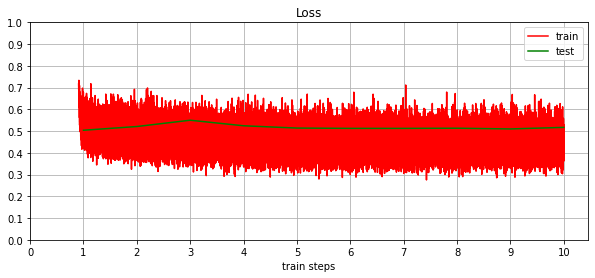

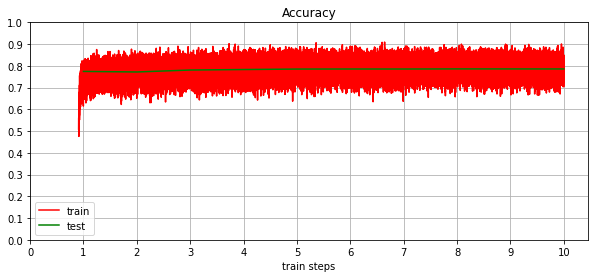

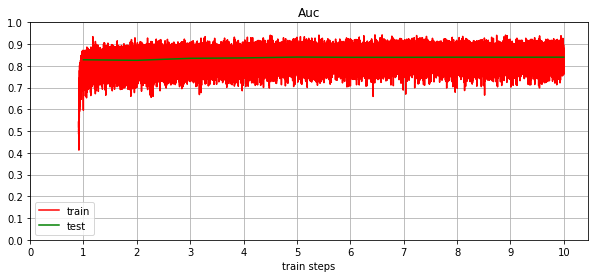

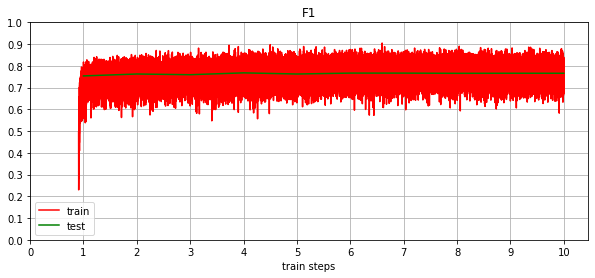

Time:  29111885.363649353
Epoch 10: ROC-AUC = 83.99%
Epoch 10: Precision = 0.758
Epoch 10: Recall = 0.776
Epoch 10: F1-score = 0.766
Final ROC-AUC = 83.99%
Final Precision = 0.758
Final Recall = 0.776
Final F1-score = 0.766
Omics features num: 30
Epoch 4
Max F1-score: 76.7719%
ROC-AUC: 83.6480%
Precision: 0.7458
Recall: 0.7935
Mean time for 1 epoch 15.32 minutes


In [17]:
train_on_reduced_omics(30)

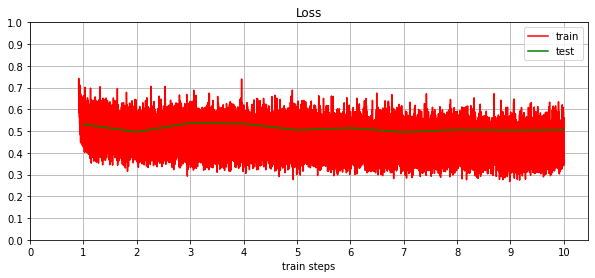

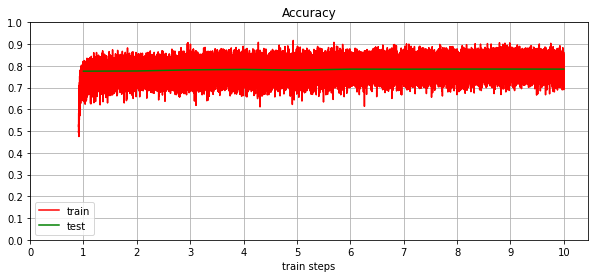

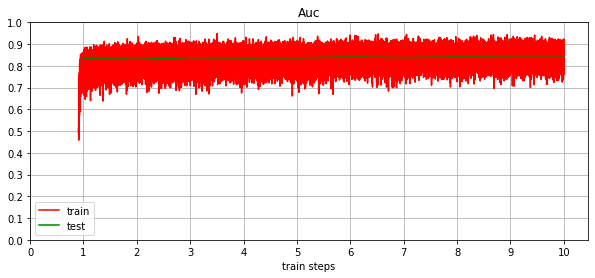

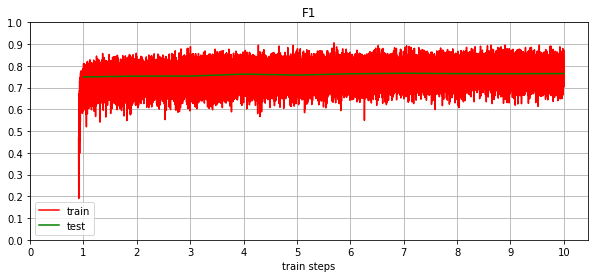

Time:  29112041.68545471
Epoch 10: ROC-AUC = 83.96%
Epoch 10: Precision = 0.759
Epoch 10: Recall = 0.773
Epoch 10: F1-score = 0.765
Final ROC-AUC = 83.96%
Final Precision = 0.759
Final Recall = 0.773
Final F1-score = 0.765
Omics features num: 20
Epoch 7
Max F1-score: 76.5904%
ROC-AUC: 83.8043%
Precision: 0.7545
Recall: 0.7802
Mean time for 1 epoch 14.29 minutes


In [ ]:
train_on_reduced_omics(20)

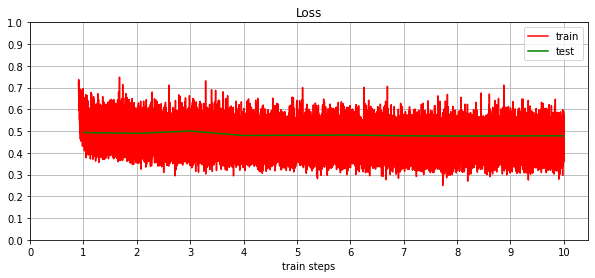

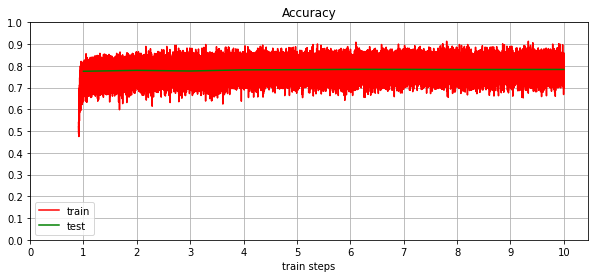

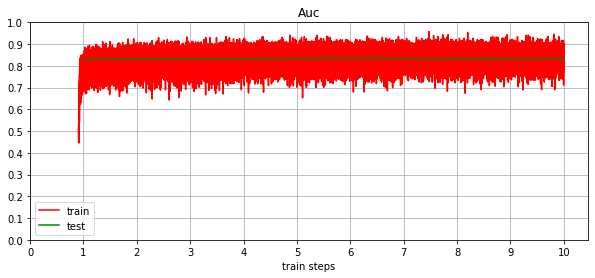

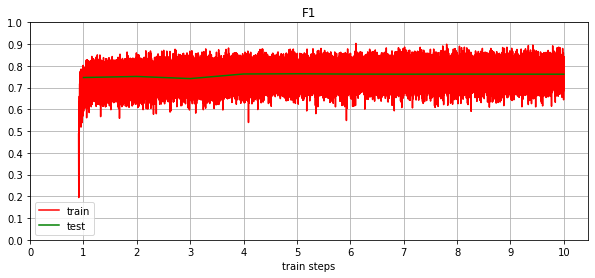

Time:  29112572.793455258
Epoch 10: ROC-AUC = 83.41%
Epoch 10: Precision = 0.761
Epoch 10: Recall = 0.765
Epoch 10: F1-score = 0.762
Final ROC-AUC = 83.41%
Final Precision = 0.761
Final Recall = 0.765
Final F1-score = 0.762
Omics features num: 10
Epoch 5
Max F1-score: 76.3497%
ROC-AUC: 83.4168%
Precision: 0.7523
Recall: 0.7775
Mean time for 1 epoch 15.63 minutes


In [12]:
train_on_reduced_omics(10)

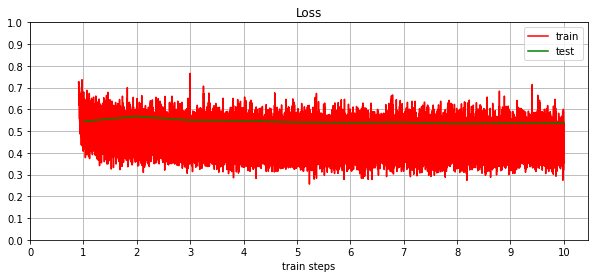

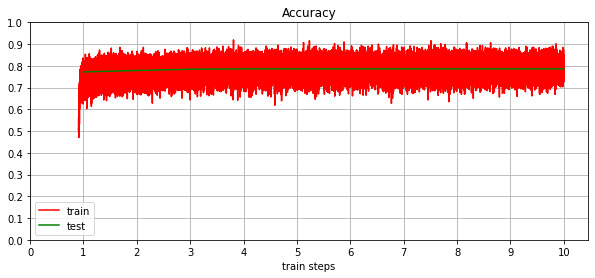

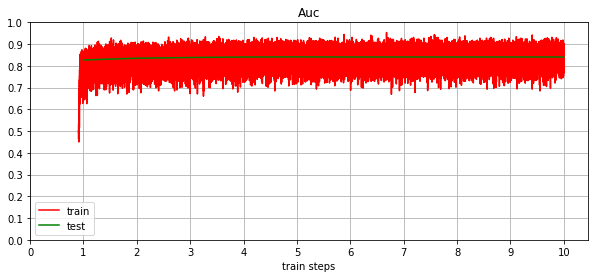

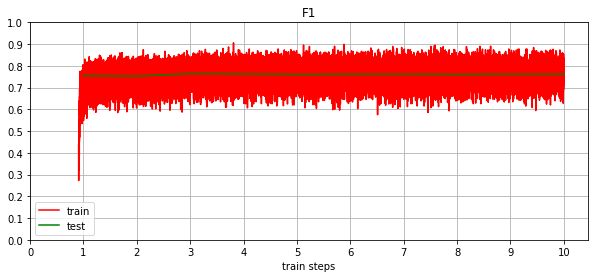

Time:  29112401.541909598
Epoch 10: ROC-AUC = 84.07%
Epoch 10: Precision = 0.77
Epoch 10: Recall = 0.755
Epoch 10: F1-score = 0.761
Final ROC-AUC = 84.07%
Final Precision = 0.77
Final Recall = 0.755
Final F1-score = 0.761
Omics features num: 50
Epoch 3
Max F1-score: 76.4351%
ROC-AUC: 83.8379%
Precision: 0.7569
Recall: 0.7743
Mean time for 1 epoch 17.93 minutes


In [11]:
train_on_reduced_omics(50)

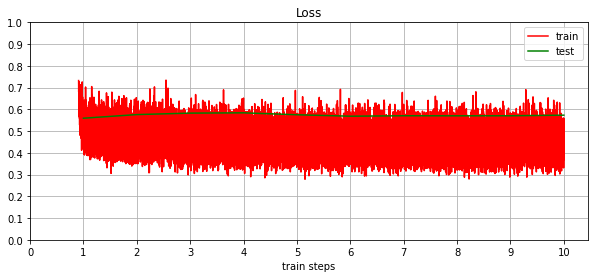

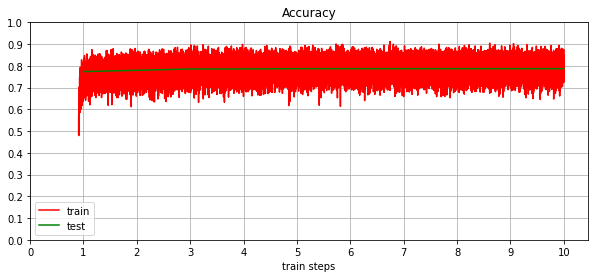

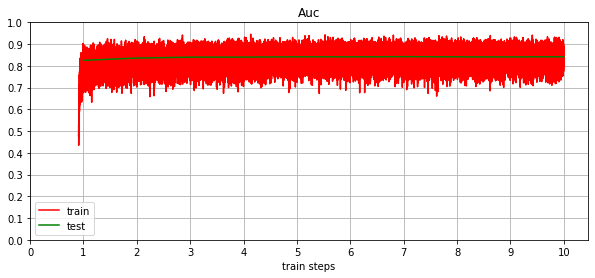

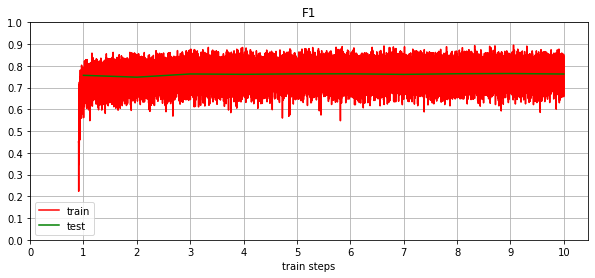

Time:  29119155.78834351
Epoch 10: ROC-AUC = 84.19%
Epoch 10: Precision = 0.771
Epoch 10: Recall = 0.757
Epoch 10: F1-score = 0.762
Final ROC-AUC = 84.19%
Final Precision = 0.771
Final Recall = 0.757
Final F1-score = 0.762
Omics features num: 100
Epoch 9
Max F1-score: 76.4655%
ROC-AUC: 84.1100%
Precision: 0.7661
Recall: 0.7658
Mean time for 1 epoch 18.15 minutes


In [12]:
train_on_reduced_omics(100)

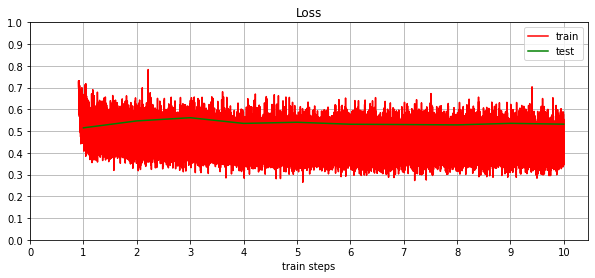

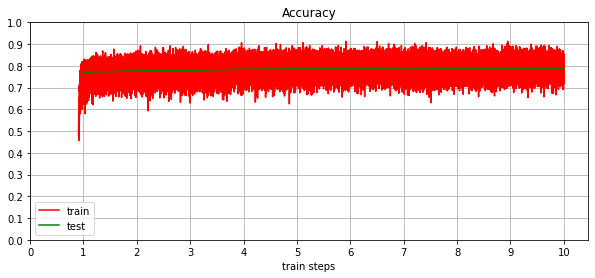

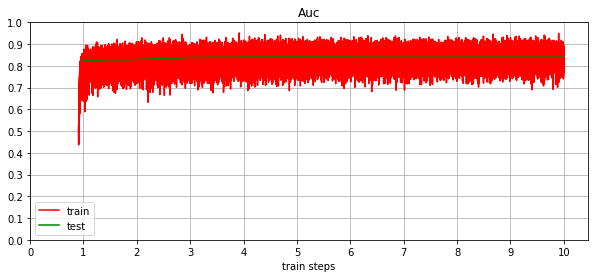

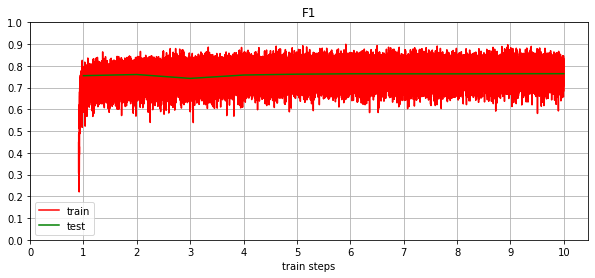

Time:  29113651.137950893
Epoch 10: ROC-AUC = 84.03%
Epoch 10: Precision = 0.764
Epoch 10: Recall = 0.766
Epoch 10: F1-score = 0.764
Final ROC-AUC = 84.03%
Final Precision = 0.764
Final Recall = 0.766
Final F1-score = 0.764
Omics features num: 40
Epoch 10
Max F1-score: 76.3979%
ROC-AUC: 84.0337%
Precision: 0.7642
Recall: 0.7662
Mean time for 1 epoch 15.64 minutes


In [43]:
train_on_reduced_omics(40)

## Postfiltered

In [47]:
features_weights = {'IG' : mean_IG, 'IXG' : mean_IXG}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)

In [48]:
features = [i[:-4] for i in os.listdir('../data_hg_38/features/sparse_max_scaled/stem_cells')
            if i.endswith('.pkl') and not "G-quadruplex" in i]

features_top = features_range.iloc[4:len(features)+4].index.tolist()

top = []
for index in features_top:
    top.append(features[index-4])

features = top

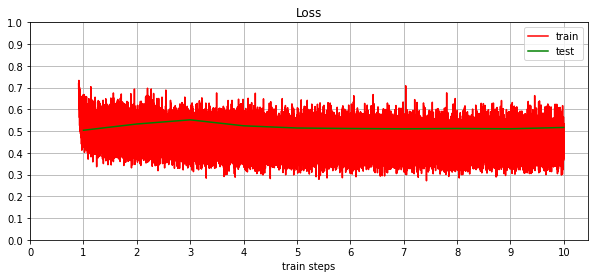

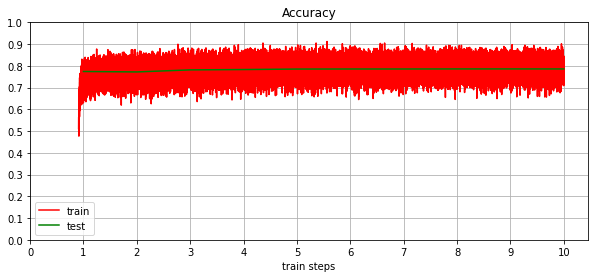

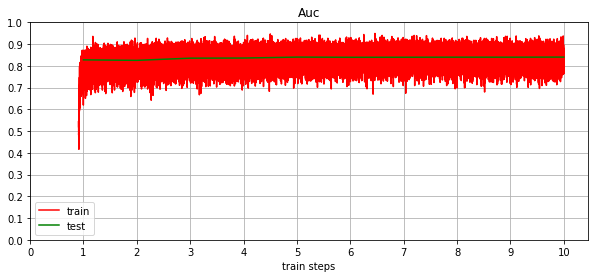

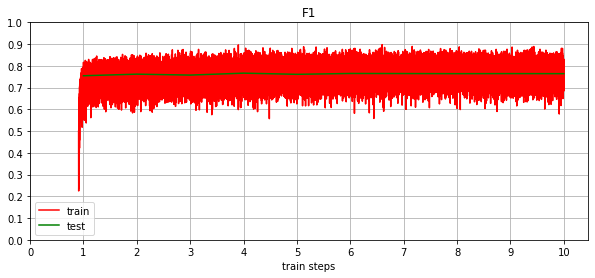

Time:  29113172.51058774
Epoch 10: ROC-AUC = 84.03%
Epoch 10: Precision = 0.762
Epoch 10: Recall = 0.768
Epoch 10: F1-score = 0.764
Final ROC-AUC = 84.03%
Final Precision = 0.762
Final Recall = 0.768
Final F1-score = 0.764
Omics features num: 30
Epoch 4
Max F1-score: 76.6394%
ROC-AUC: 83.5913%
Precision: 0.7483
Recall: 0.7878
Mean time for 1 epoch 15.64 minutes


In [28]:
train_on_reduced_omics(30, "postfiltered")

# Different rankings

In [61]:
def get_ranked_feature_names():
    features = [i[:-4] for i in os.listdir('../data_hg_38/features/sparse_max_scaled/stem_cells')
                if i.endswith('.pkl') and not "G-quadruplex" in i]
    features_top = features_range.iloc[4:len(features)+4].index.tolist()
    
    top = []
    for index in features_top:
        top.append(features[index-4])

    features = top
    
    return features

## Width 50

In [66]:
mean_IG = torch.load(f'./interpretation_results/g4/width50/mean_IntegratedGradients.pt')
mean_IXG = torch.load(f'./interpretation_results/g4/width50/mean_InputXGradient.pt')

mean_IG_prefiltered = torch.load(f'./interpretation_results/g4/width50/mean_IntegratedGradients_prefiltered.pt')
mean_IXG_prefiltered = torch.load(f'./interpretation_results/g4/width50/mean_InputXGradient_prefiltered.pt')

### Prefiltered

In [63]:
features_weights = {'IG_prefiltered' : mean_IG_prefiltered, 
                    'IXG_prefiltered' : mean_IXG_prefiltered}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features = get_ranked_feature_names()

In [64]:
features[:20]

['TFs_and_others_TP53BP1',
 'TFs_and_others_KDM1A',
 'TFs_and_others_BCOR',
 'Histone_H3K4me3',
 'TFs_and_others_NANOG',
 'ATAC-Seq_ATAC-Seq',
 'TFs_and_others_TFEB',
 'TFs_and_others_CREB1',
 'Histone_H3K27ac',
 'TFs_and_others_KDM2B',
 'TFs_and_others_Crotonyllysine',
 'TFs_and_others_TWIST1',
 'DNase-seq_DNase-Seq',
 'TFs_and_others_QSER1',
 'TFs_and_others_TFAP2C',
 'Histone_H3K4me2',
 'TFs_and_others_RAD21',
 'TFs_and_others_Epitope_tags',
 'TFs_and_others_ASCL1',
 'TFs_and_others_CTCF']

In [65]:
torch.save(features, "./interpretation_results/g4/width50/best_omicses_ranking_prefiltering.pt")

### Postfiltered

In [67]:
features_weights = {'IG' : mean_IG, 'IXG' : mean_IXG}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features = get_ranked_feature_names()

In [68]:
features[:20]

['TFs_and_others_BCOR',
 'ATAC-Seq_ATAC-Seq',
 'Histone_H3K27ac',
 'DNase-seq_DNase-Seq',
 'TFs_and_others_CTCF',
 'TFs_and_others_YY1',
 'TFs_and_others_KDM1A',
 'Histone_H3K4me3',
 'TFs_and_others_MAX',
 'TFs_and_others_TP53BP1',
 'RNA_polymerase_RNA_polymerase_II',
 'TFs_and_others_KMT2A',
 'TFs_and_others_TET1',
 'TFs_and_others_RAD21',
 'Histone_H3K4me2',
 'TFs_and_others_Epitope_tags',
 'TFs_and_others_TFEB',
 'Histone_H3K27me3',
 'TFs_and_others_NANOG',
 'TFs_and_others_FOXA2']

In [69]:
torch.save(features, "./interpretation_results/g4/width50/best_omicses_ranking_postfiltering.pt")

## Width 100

In [70]:
mean_IG = torch.load(f'./interpretation_results/g4/width100/mean_IntegratedGradients.pt')
mean_IXG = torch.load(f'./interpretation_results/g4/width100/mean_InputXGradient.pt')

mean_IG_prefiltered = torch.load(f'./interpretation_results/g4/width100/mean_IntegratedGradients_prefiltered.pt')
mean_IXG_prefiltered = torch.load(f'./interpretation_results/g4/width100/mean_InputXGradient_prefiltered.pt')

### Prefiltered

In [71]:
features_weights = {'IG_prefiltered' : mean_IG_prefiltered, 
                    'IXG_prefiltered' : mean_IXG_prefiltered}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features = get_ranked_feature_names()

In [72]:
features[:20]

['Histone_H3K4me3',
 'TFs_and_others_KDM1A',
 'DNase-seq_DNase-Seq',
 'TFs_and_others_TFEB',
 'TFs_and_others_BCOR',
 'TFs_and_others_EP300',
 'TFs_and_others_Epitope_tags',
 'TFs_and_others_TP53BP1',
 'ATAC-Seq_ATAC-Seq',
 'Histone_H3K27ac',
 'RNA_polymerase_RNA_polymerase_II',
 'TFs_and_others_QSER1',
 'TFs_and_others_TET1',
 'TFs_and_others_TAF1',
 'TFs_and_others_Crotonyllysine',
 'TFs_and_others_NANOG',
 'Histone_H3K27me3',
 'TFs_and_others_HNF4A',
 'TFs_and_others_TFAP2A',
 'TFs_and_others_RUNX1T1']

In [73]:
torch.save(features, "./interpretation_results/g4/width100/best_omicses_ranking_prefiltering.pt")

### Postfiltered

In [74]:
features_weights = {'IG' : mean_IG, 'IXG' : mean_IXG}
features_weights = pd.DataFrame(features_weights)
features_range = get_ranked_features(features_weights)
features = get_ranked_feature_names()

In [75]:
features[:20]

['TFs_and_others_BCOR',
 'ATAC-Seq_ATAC-Seq',
 'Histone_H3K4me3',
 'TFs_and_others_Epitope_tags',
 'Histone_H3K27ac',
 'TFs_and_others_TP53BP1',
 'DNase-seq_DNase-Seq',
 'RNA_polymerase_RNA_polymerase_II',
 'TFs_and_others_TFAP2A',
 'Histone_H3K27me3',
 'Histone_H3K4me2',
 'TFs_and_others_EP300',
 'TFs_and_others_TFAP2C',
 'Histone_H3K18ac',
 'TFs_and_others_KMT2A',
 'TFs_and_others_KDM1A',
 'TFs_and_others_TET1',
 'TFs_and_others_MXI1',
 'TFs_and_others_CTCF',
 'TFs_and_others_RAD21']

In [ ]:
torch.save(features, "./interpretation_results/g4/width100/best_omicses_ranking_postfiltering.pt")